In [8]:
%%bash
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
technical_indicators_scaled_day = pd.read_csv('/content/drive/My Drive/technical_indicators_scaled_day.csv', index_col=0)
ticker_data_day = pd.read_csv('/content/drive/My Drive/ticker_data_day.csv', index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Define a function to label the data based on the fixed number of days (d)
def label_data_fixed_days(row_index, d, close_prices, binary=True):
    if row_index + d >= len(close_prices):
        return None
    current_price = close_prices.iloc[row_index]
    future_price = close_prices.iloc[row_index + d]
    if binary:
        return 1 if future_price > current_price else 0
    else:
        return 1 if future_price > current_price else -1

d = 1, Average accuracy: 0.5178021978021977
d = 2, Average accuracy: 0.4936263736263736
d = 3, Average accuracy: 0.5199999999999999
d = 4, Average accuracy: 0.4703296703296703
d = 5, Average accuracy: 0.487032967032967
d = 6, Average accuracy: 0.492511013215859
d = 7, Average accuracy: 0.48325991189427303
d = 8, Average accuracy: 0.49207048458149777
d = 9, Average accuracy: 0.49339207048458145
d = 10, Average accuracy: 0.5303964757709252
d = 11, Average accuracy: 0.5317180616740088
d = 12, Average accuracy: 0.539514348785872
d = 13, Average accuracy: 0.5364238410596027
d = 14, Average accuracy: 0.543046357615894
d = 15, Average accuracy: 0.5977924944812362
d = 16, Average accuracy: 0.6022075055187639
d = 17, Average accuracy: 0.598233995584989
d = 18, Average accuracy: 0.6110619469026549
d = 19, Average accuracy: 0.6358407079646018
d = 20, Average accuracy: 0.6442477876106194
d = 21, Average accuracy: 0.6615044247787611
d = 22, Average accuracy: 0.7238938053097346
d = 23, Average accur

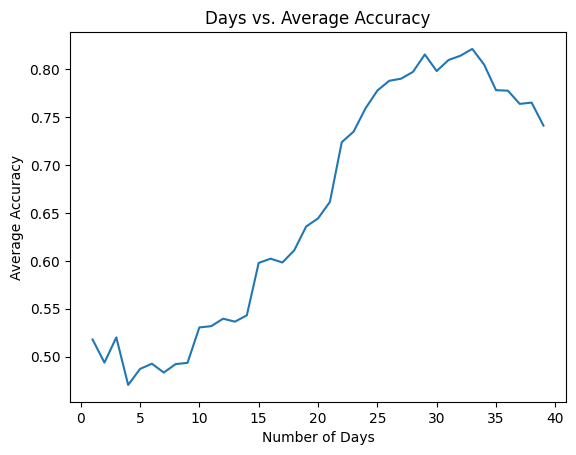

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt

d_values = list(range(1, 40))  # Test different values of d
best_d, best_model, best_accuracy, best_report = None, None, 0, None
accuracy_results = []

for d in d_values:
    # Label the data using the current value of d
    technical_indicators_scaled_day['Label'] = 0
    for idx in range(len(technical_indicators_scaled_day)):
        binary_label = label_data_fixed_days(idx, d, ticker_data_day['Close'], binary=True)
        if binary_label is not None:
            technical_indicators_scaled_day.loc[technical_indicators_scaled_day.index[idx], 'Label'] = binary_label

    y = technical_indicators_scaled_day['Label'].values
    X = technical_indicators_scaled_day.drop(columns=['Label'])

    # Remove the last d rows
    X = X.iloc[:-d]
    y = y[:-d]

    k = 7  # Select the top k features
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_kbest = selector.fit_transform(X, y)

    # Define the XGBoost model
    model = XGBClassifier(eval_metric="logloss")

    tscv = TimeSeriesSplit(n_splits=5)
    accuracy_scores = []
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in tscv.split(X_kbest):
        X_train, X_test = X_kbest[train_index], X_kbest[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred.flatten())

    # Calculate the average accuracy
    average_accuracy = np.mean(accuracy_scores)
    accuracy_results.append(average_accuracy)

    if average_accuracy > best_accuracy:
        best_d = d
        best_accuracy = average_accuracy
        best_model = model
        best_report = classification_report(y_true_all, y_pred_all)

    print(f"d = {d}, Average accuracy: {average_accuracy}")

print(f"Best d value: {best_d}, with average accuracy: {best_accuracy}")
print("\nClassification report:")
print(best_report)

# Plot the accuracy graph
plt.plot(d_values, accuracy_results)
plt.xlabel("Number of Days")
plt.ylabel("Average Accuracy")
plt.title("Days vs. Average Accuracy")
plt.show()
